In [9]:
import os

image_list = []
root = "./Product/Validation/label/"
category = []

for dir in os.listdir(root):
    os.rename(root + dir, root + dir.split("_")[0])

In [14]:
import os

image_list = []#glob(u'./상품 이미지/Validation/[원천]유제품/10246_토핑오트_애플시나몬/*.jpg')

root = "./Product/Training/image/"
category = []
categories = {}
for dir in os.listdir(root):
    for file in os.listdir(root + dir):
        if file.endswith(".jpg"):
            # image_list += os.path.join("/mydir", file)
            image_list.append(os.path.join(dir, file).replace("\\","/"))
    category.append(dir)
# image_list
# for (i, cat) in zip(range(len(category)), category):
#     print(i, cat)
print(category)
categories = {cat:i for (i, cat) in zip(range(len(category)), category)}
category = [{"id": i, "name":cat} for (i, cat) in zip(range(len(category)), category)]

from sklearn.model_selection import train_test_split
train_img_list, val_img_list = train_test_split(image_list, test_size=0.2, random_state=2000)
# val_img_list, t = train_test_split(val_img_list, test_size=0.9, random_state=2000)

with open('./Product/Training/train.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(train_img_list) + '\n')
    
with open('./Product/Training/test.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(val_img_list) + '\n')

['10246', '10247', '10248', '10249', '10250', '10252', '10253', '10254', '10256', '10257', '10259', '15122', '15126', '15128', '15129', '15130', '15131', '15132', '15134', '15139', '15142', '15143', '15144', '15184', '15185', '15186', '15187', '15188', '15189', '15190', '15191', '15193', '15194', '15195', '15196', '15208', '15209', '15210', '15211', '15212', '15213', '15214', '15215', '15216', '15217', '15218', '15219', '15222', '15343', '15876', '15877', '15880', '20061', '20240', '20243', '20245', '20246', '20247', '20248', '20249', '20250', '20251', '25122', '25123', '25124', '25125', '25126', '25127', '25128', '25129', '25155', '25156', '25157', '25158', '25160', '25161', '25162', '25169', '25177', '25196', '25208', '25210', '25238', '25239', '25244', '30208', '30209', '30210', '30211', '30212', '30213', '30214', '30215', '30216', '30217', '30218', '30219', '35024', '35061', '35075', '35117', '35118', '35126', '35127', '35128', '35129', '35131', '35132', '35133', '35134', '35135', 

In [11]:
import os

image_list = []

root = "./Product/Validation/image/"
# category = []
for dir in os.listdir(root):
    for file in os.listdir(root + dir):
        if file.endswith(".jpg"):
            # image_list += os.path.join("/mydir", file)
            image_list.append(os.path.join(dir, file).replace("\\","/"))
    # category.append(dir)
# len(category)
# category = [{"id": i, "name":cat} for (i, cat) in zip(range(len(category)), category)]

with open('./Product/Validation/val.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(image_list) + '\n')

In [18]:
import os.path as osp
import mmcv
import json
import xmltodict

# CLASSES = ('traffic_light', 'traffic_sign', 'traffic_information')
# cat2label = {k: i for i, k in enumerate(CLASSES)}
# categories = {"치즈" : 0, "요구르트": 1, "우유":2, "레저취미":3, "버터":4}

def convert_data_to_coco(ann_file, out_file, image_prefix):
    global categories
    global category
    data_infos = mmcv.list_from_file(ann_file)
    annotations = []
    images = []
    
    idx = -1
    obj_count = 0
    last_category_id = 0
    for filename in data_infos:
        idx += 1
        
        img_path = osp.join(image_prefix, filename)
        
        height, width = mmcv.imread(img_path).shape[:2]
        
        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))
        with open((img_path[:-4] + "_meta.xml").replace("image", "label"), 'rt', encoding="UTF-8") as f:
            dic = json.loads(json.dumps(xmltodict.parse(f.read())))['comp_cd']
    
        bboxes = []
        labels = []
        masks = []
        
        if dic['div_cd']['div_m'] not in categories.keys():
            categories[dic['div_cd']['div_m']] = last_category_id
            last_category_id += 1
        elif "object" not in dic['annotation'].keys():
            continue
        objs = dic['annotation']['object']
        if type(objs) != list:
            objs = [objs]
        for obj in objs:
            box = [int(obj['bndbox']["xmin"]), int(obj['bndbox']["ymin"]), 
                   int(obj['bndbox']["xmax"]) - int(obj['bndbox']["xmin"]), int(obj['bndbox']["ymax"]) - int(obj['bndbox']["ymin"])]
            
            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=categories[dic['div_cd']['item_no']],
                bbox=box,
                area=height * width,
                segmentation=[[]],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1
            
    # categories = [{"id": 0, "name": "Cheese"}, {"id": 1, "name": "Yogurt"}, {"id": 2, "name": "Milk"}, {"id": 3, "name": "Hobbies"}, {"id": 4, "name": "Butter"}]
    # return
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=category)
    # 확인용
    print(json.dumps(coco_format_json, indent = 4, sort_keys = True, ensure_ascii=False))
    # with open(out_file, 'w', encoding='utf-8') as f:
    #     json.dump(coco_format_json, f, ensure_ascii=False, indent = 4, sort_keys = True)
    mmcv.dump(coco_format_json, out_file)
    
convert_data_to_coco('./Product/Validation/val.txt',
                        './Product/Validation/annotation_coco_val.json',
                        './Product/Validation/image')

convert_data_to_coco('./Product/Training/test.txt',
                        './Product/Training/annotation_coco_test.json',
                        './Product/Training/image')

convert_data_to_coco('./Product/Training/train.txt',
                        './Product/Training/annotation_coco_train.json',
                        './Product/Training/image')



{
    "10246": "요구르트",
    "10247": "우유",
    "10248": "우유",
    "10249": "요구르트",
    "10250": "요구르트",
    "10252": "우유",
    "10253": "요구르트",
    "10254": "요구르트",
    "10256": "요구르트",
    "10257": "요구르트",
    "10259": "요구르트",
    "15122": "요구르트",
    "15126": "치즈",
    "15128": "버터",
    "15129": "치즈",
    "15130": "요구르트",
    "15131": "요구르트",
    "15132": "요구르트",
    "15134": "요구르트",
    "15139": "요구르트",
    "15142": "요구르트",
    "15143": "요구르트",
    "15144": "요구르트",
    "15184": "치즈",
    "15185": "요구르트",
    "15186": "요구르트",
    "15187": "요구르트",
    "15188": "요구르트",
    "15189": "요구르트",
    "15190": "요구르트",
    "15191": "요구르트",
    "15193": "요구르트",
    "15194": "우유",
    "15195": "우유",
    "15196": "우유",
    "15208": "우유",
    "15209": "우유",
    "15210": "우유",
    "15211": "우유",
    "15212": "우유",
    "15213": "우유",
    "15214": "우유",
    "15215": "우유",
    "15216": "우유",
    "15217": "요구르트",
    "15218": "우유",
    "15219": "우유",
    "15222": "요구르트",
    "15343": "치즈",
    "15876": 

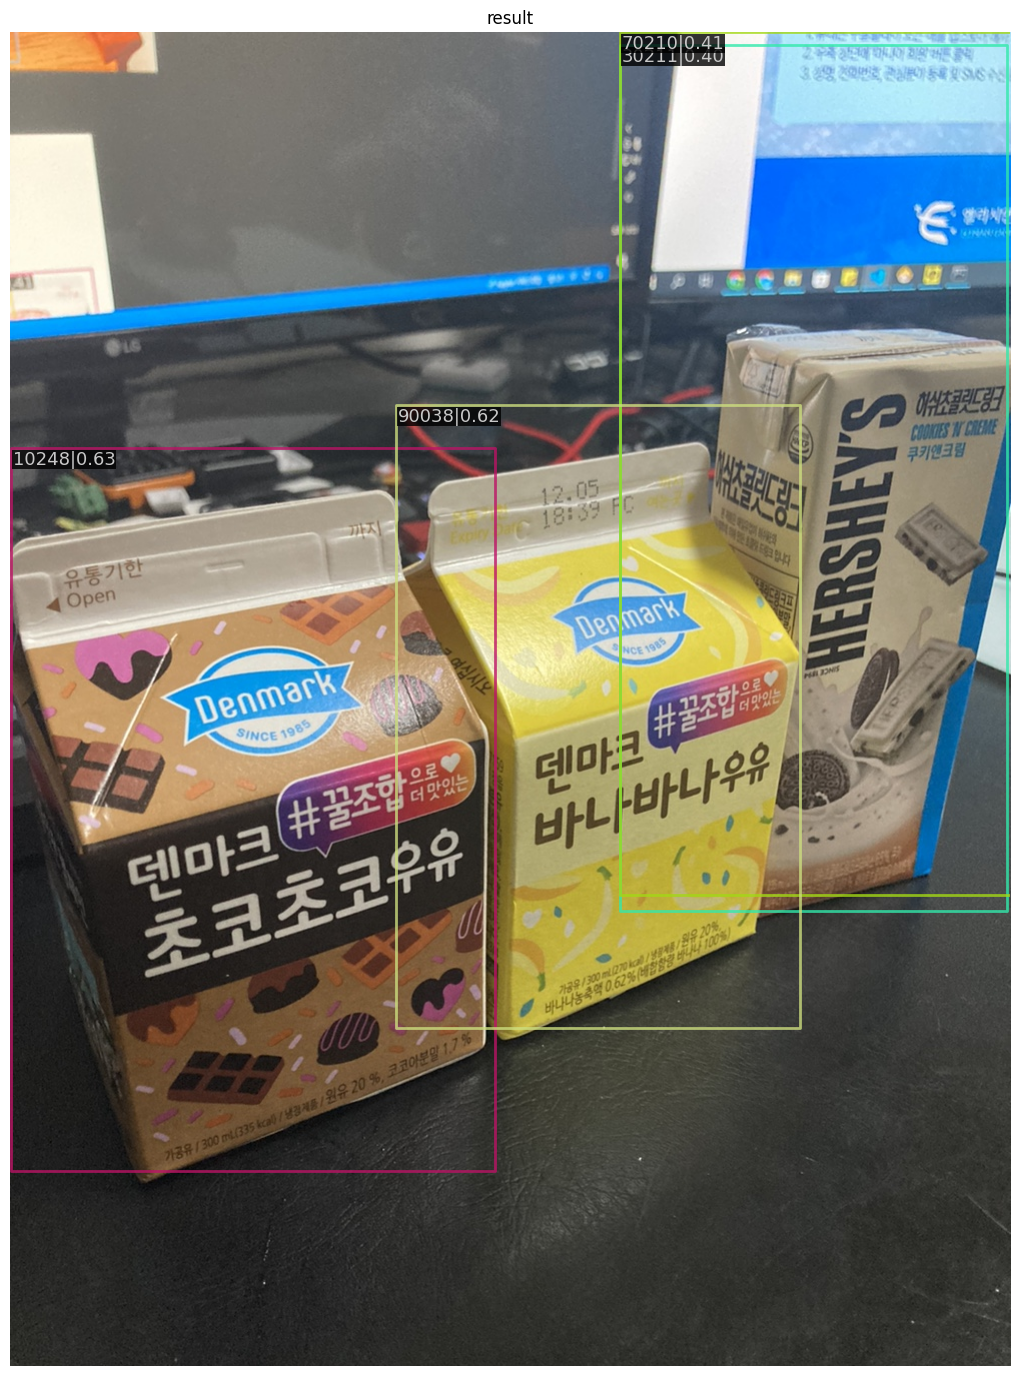

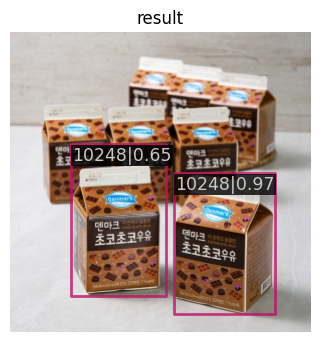

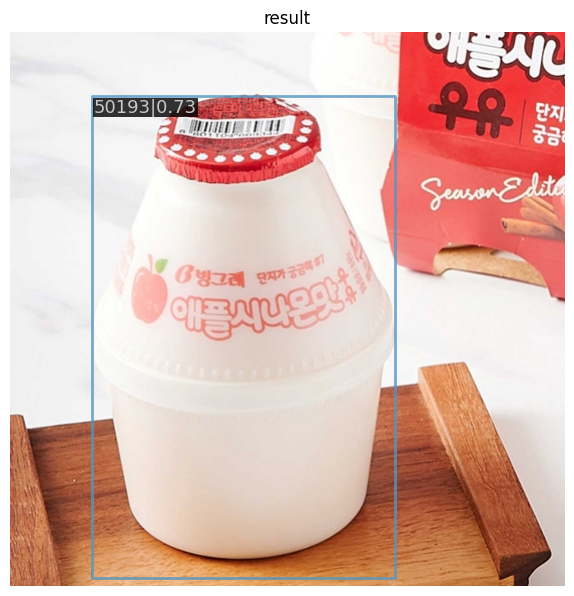

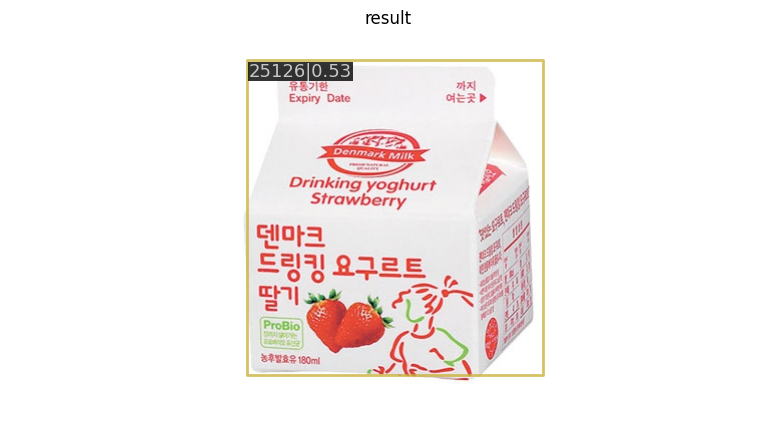

In [62]:
import torch
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector
PATH = './weights/'
device = torch.device("cuda")
model = torch.load(PATH + 'model.pt')
model.to(device)

img = mmcv.imread('./TestImage/KakaoTalk_20221125_220542890_04.jpg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)#score_thr

img = mmcv.imread('./TestImage/TestImage05.jpg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)#score_thr

img = mmcv.imread('./TestImage/TestImage02.jpg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.4)#score_thr

img = mmcv.imread('./TestImage/TestImage07.jpg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.5)#score_thr


In [48]:
data = """/9j/4AAQSkZJRgABAQEAYABgAAD/5wAIbHAwMQAA/9sAhAAICAgICQgJCgoJDQ4MDg0TERAQERMcFBYUFhQcKxsfGxsfGysmLiUjJS4mRDUvLzVETkI+Qk5fVVVfd3F3nJzRAQgICAgJCAkKCgkNDgwODRMREBARExwUFhQWFBwrGx8bGx8bKyYuJSMlLiZENS8vNUROQj5CTl9VVV93cXecnNH/wgARCAEsASwDASIAAhEBAxEB/8QAHAAAAQUBAQEAAAAAAAAAAAAAAgEDBAUGAAcI/9oACAEBAAAAAPTOUuTu5OBeFW2kAe5BFvmwQBReBNaImaCvcgcrfI02DQFyCLaAicKqKapV5UQOXgEe5BZabYDk4ibERFonRb2Hc5w82pcgIgX6MMM1sJI68nCySc002xvlJUQxVCQQ4dFMc4YcJmPEr4qIHACxXE2fcXAncncKJDrb63qWNPKNG6+ELMeLWkicGoEiXkVB5seAJOkraDPTtJJqommluI2xjgHkDTtuECuiIpwjUeXaHPyddc2enz9BXsX93HpmqW+FEHTrzgE2Sj3CFR5k81Bpd0NHa3WnTXdkKTBVXs5tCOtLieDjREjuLGobUZPks6VUyJN3eYdp2xxVnunR4NIRLMjSSRltp2HIdEWfHfTrKS4nB4nhjl38/fOAK3vd1NHrNGdRQW9idbYNUkGu19uyUaD0VGPO7mw37gJ3oSp3kldrNHNzuWo85f6rWy6bGZ3Kam13k/O4qHn4lxMtvTEbQdwvLhfLXpFvWMNN2rNrqctnwze1r73aZnISYVJpWbT1zkTr1VLzzw7bjSNsUNxJs49QyzX3tkxFZjpH07tpE1uoluuLoeJcR827dgkKgdh66BCB+odHcVVZWPs7lZWac3Fk+85uyLsf85brmolRXXAehvSaGhzcqD6I3KWrzunWJAsNE49Ik+jF3Zf58dK79jly3ETh8w8ujWA2nVZwD9Rsbg+fLjPUIK5rwgu03rTc1wuA/MPORj6DcehV8Gop/QpnMgopxXPcuf8An7o20v4sE616keq+rY+i2Xo4TSRsWIzjhmYXq8lZ89PpTbKvm6S5XOZt6pgZ/ZbfQz5r8hgY+SemTZLhX/dw+ZNyqejrL2+00HC1TOimxXpkuHfwIVbrpmG170mS4t2XKPC3hszgLiHqDiS3bX0pKaisJFVLr87mAwfsvpncq25Lwtp2Hx+ZeeVhBqtT7tRebXlTuLXKVcOtw9j6B6QKItwvIAEmL8+xOyrI9WhN7H3jy7xc5VnbyLSTHzdrpvQQ4UuhHu7hxmF832dtEYukoJvu3mfleprM1CZblemR02O6Hh61TlRFbxGMwepAYx1cbee2ea+VG0NQbld6SzI2G7HgKz5RQeDD5zBTJhWblTQei+veZ+U29pJpFq8n6bGlbDciqLYdyIijhKTKtTTnxauVrfT8R49HiTCbnY70yNJ2e3FV6d3cor2GzHmWgG3bqNLnr/Y1GNprMH869A9AgytjtSIund3CqjU+a4y4zOpp578GVOYxVjPb7q6Jv6WZuNQ48XWIpwumLXkeasReY6NNgp2dnnNyVw1ZXee0Wiv35ZnaoiK/wdkPMGzZlWxtcVPDOmcerrKNq87fzbKVOff13cjg93JEhxI8ZO544mbrmGQViDf0ejmOc8456Q5xNiSKPcHA3yJzAuN5+uqa6NZ88ZuAperLwCq93dyiAkraIzwIndXNVbLQK0J+n8o8nL3dy8gECKLLfJy8qNoABFZHZI2q8qcncpN8YcgssOCinwD3GjQJ/8QAGgEAAgMBAQAAAAAAAAAAAAAAAAECAwQFBv/aAAgBAhAAAACICAEmIYxggQxRGAEgAVcLVaRABgIKivH2eNs01WtMQJpQspjZZz9V4GKc6LU6NDaddlxauJp28mWrZxLtXR4GizVaSM7iqrovPenintucjFG2cLIV0akUXXTcjn0XsUI17bCcm2LJRkq9pl8vsKtJK2+QwXPGnqpzego8/fvtYIzScS2FdEI3bbAQY1FS0SjGKhrsBBgzE4780J3xWqwEGLDIh0IZ7Izs1zaBQok3LLRFPVplJiAExEKYaG3MEAMQAAf/xAAaAQACAwEBAAAAAAAAAAAAAAAAAQIDBAUG/9oACAEDEAAAAJCYA2IGiIwYAm2IAEABbZTKkYAAAy92beJ3MGa2iIwAcnZC2ddXT59AzbWr6Q05ojJU1EH3cWD0FGHB6bPi5XqslGSkRpjN2UzV9Elur51QG2VNcq56LskiymiIHS0Zqm7dCwVEIoA2XbLfA7Pb8t6MFldFACZ0JJrHo2eQv9pz8FImGuCmqZ2aLLKMNQAbnKSyRcpO7FWAHQ2yhLl65QzSlkrADdvirOZdpFHPjgAE7oJLXom1iyJMAGAydss0UAAADAAR/8QAMhAAAgEDAwIEBQMEAwEAAAAAAQIDAAQRBRITFCEQICIxBhUwMkEjMzQkQEJRFjVDYf/aAAgBAQABCAHzYrHk21isVjv4HyZ8uazW+s1ms1uok1k1nw7+UeOaz5M+JPiTWaJFEit1ZFZrNZ8M1kVnPhn62fDPk/Fdj5DRoiiDWDWDXqr1VlqNdqxRrtRrJrJ8M1k/2McEewZNtGaNmlGyo2T1LC8eM1gUUFbBW2uOtgrZ/o7xX/2u/gQ1bjRc1yH+xSWAgADb5JFVvuNtCaNnHRshXQsD2ljeM4PfyYrFbawK25OK4hXCPDt5DWazWfHIrt4zM6oSkDSTKd0NtxjvwofaWSdBhbfUyz7ZFlt37qNv4xWDRp1B9+GI10qV0i0bU/jppcGsGseGPDNZrIzWR5seYkAZLx8v7axSKVAQ9sG5bauVl5ThquZLiIDYiPOi1HCqAKxt1xlJpp1+2PVyzqtLLaynsFT8bTWGrv8An/dH3PmwK/NBRWPDv4Zoms1ms+N9/EnrSbS1uIXMp0+aPYYZdR1O2neKhr2qitO1e6undLjpZ3cMYROJDXIhHe6nETKRK77u7PLFGWFtcNMrVDbtGCWEcbez80FfM5YD+rNre2B3qzvlul8c+PbyY7+BrtXasVjyX38SatCtVlW6JhsZltHnju9NmBgen0q8RmFXME8USNJFpVu8KNF0epROVSPWtUFL8RagPug+I5ZZUjadLtm9Gx4gm6Ertw0oiwcNcBwVDHd9uqzs7iKrRZkkV0RiyqfHvXfw7eIAxWUHagQe3h3rvWSKc+1KuRmtlTQLLE6Gy0wWasqizt+IxVLaQycWSkWTn4geMGOBY9Mnm0uHh+V6tHtCn4cvAxAX4cufyvw3IG3GLSLmP2S1uV97jWdQtJjFKPiV/wDJPiK2HvHq9hcERrwJyuzDCjtGP01rFY84Vinbgk/IjIrYa2UUrAr0/jOEr1FqVcZrvXevVRBJrWoZJLxsaW5+XxM/J6qXPfPjjvmtdWdrp5aLkDvyDGK0vvqENE4kNZ7Um7aK9VZastXev1azLW6Wg7/k3MkrTxpG04BzFLqEkuHFvLJ7jSxnIvNOZtoMxuII0SHTmuFP68WriVZ+FdSuCpLR600z7EN1ft+2H1f3e5m1XcOOfUpIsB3k513nTdVtekZKXVoGGQNZgY4VtVAoatITU2s3SMNsmtmMd5brq7GbDhVsY+YRWktzPjTAPmQwfuofigfSPA+b8UkBS+uRT2XEcrDIvYVClvKgo2qj2uJRBgzNcxBSyzMZEl26G0kdxPDRm1GM+q3SMECoo5ioKf1S+8mZGGXWId5NQ5ZbaTGiTFLvjp72ZGbktYbbKyVCsiKDFzze0k3TSOCJLaKRtzzRwzLxCS1VI2NJAxXfHpMBF2Gr81EMlRQgfArgeuB64JK4JPLLhSzm4jM0neTjFuIo7W7WGPD/ADYYqe5gnUq0MsUMexDdLEd1aYoecSDULm5jkKRrLdx25ZtP1G62sT81lxV9LJcIwMIRY8T77UHvFakTckN9dCPBWC6m42kew1qYs9fOVxV5fXEoPFH1MyvzIkgYVJGqTbGbbITCNNt1ilyKt1PItA9vo6l/HuKso+qn42GkxjZhbaCKdFkkn2SyoOqo3LEVNIzGrC4aKfsb67ecxqYtUIzRt7veqPKjRyvG/prtjNOSD2tLniuVze6g/MQpm1LBNbtQ3ACSW+Ryj8tya/Xam3j3mKpb2DF3AwRp5O9yfyKysINRzblBoPW+s1ny365huaRHaRVTU7a5QxOXi1C3g5Vu7B47ZbknTD00kwfTI1aAVfW6wS4W0QM7GndoroyJPfTpBC6tfXJRWluIp5Qbw9FecRlrobv9KryB4WAaGLklq49M1HVG6YSBtUjlChrpzcPzqASMjZKFRqnilifbIpi6e1D7EkFWsQieSmchq3SyNmSBiqAUJK5aEprl8t2MpPVsE6hN99PZzpFV1e2stsIan1GyktuGvmNqLcRJ8yuiYDVxLNcvuaxhn5GptPv3mJF5Z3c1ikaGxv3sXjp9OvGseCjH0VuYZzqkZ6WtSuVuZQ62H8irv996YR/Kdgg2HTzut0f5Xx1YidbL1m8thFaitVlgklj4Y4Ee3tWMpjU+l7pEyFUsfsit++WAxXegDQBrbWKx43I7TUYbffipIraPGdltsDDS7OG5uwjiwsU9lihH2rn8eqsGsVijXxBBFJJbFoViZiDK0eQEs/5TVcW87TMyiXWX9AePWVGHxdEhT0cp944YXfbTR26nFR6XLcQwFF0CL/0XSLNfY6bF+BYxiulSumWuAVxCuMeW4/8ASmlhSX1ScDpvaJopIzt0Ny98Kcy7goVJcjIXFY8MUa7V8QNH/StUzOpHGQqrmrQ4u2NSKXK1oygTuCzbRmmjtpMlm06xfvR0OxySv/HYlJK20fFBHGfAnxz9C7TAY1PFF3LJHEsNRTRL2qyuBazwtVxrNxG20Nq16Bll1i7c4V9QvqN7qb/as1833v8AM+RqmmjT7y8U8TVHKrR9pDk5aFylyTVwsrqhT4cE7Sz7nhuCXoRN3DKNowK9NECipxmlI/Bm7kUJK31urPnulzE1SQcxIpIeNdtLaRvKorUorqOTdJcXyKkch6u1mUq0FlBGdwiQptIW6lp5EkX9SWFUMmXtY5myf6eKPbRVEJWpQmM0GxM2ZGfgGyzS6trRSIb69UZlXVFaheW5GSJbdvbjJ7gxtTZ9qVQDkO55HpXNBqVqB85AIIqTQnLsU+QyfmLReKRJKvrQSrgQqstrGGaCzidXYSK20m3uYd3rCWLDvLDZbSTc3lrbe/UCSMmHeu/c0NgLrL18kofDyZJqCykSfDm8l5DukCXMOFhs1hclltHmB2TabcpgtFG8Y20+panHLhV1GbA3/MYwuWtNQtrpyK4TQioJQFY8M+c+xphklauItqysnRXUjkM1pItu0aWdvNG53BJB9pXvmR7aGZdpis1jXCm1UjvpEp6yaJttYqaRAe7LBPJ34xjFJAzKcvbwqfVHNNFt2TBS7VNvMbBOmvZPe8laG12EZzkaHqEsh6ebH0c+J+01N2Z86rLsSB6W6muGKwr1noNNLeJ98sksSI7dRIDXUS9q5mOMy3D4GPhs7tRfwv7yKyg5JGuVuWPGn6Idxb6jNLcbSl0FrrYyuKu5LEAvQlilRTHvUkqFa4OAbuTnnOy2s/y2nqOpjA+hnyH2NTD1OK1oYhjq2nERkzdXU0TgSG9jeIpV1cpLCqUDGK9Haj2950kjIV/hj/sJvD4qGbSCorSWVJHV1vLQgFNTvVpNZlH3R61B/nLd2d1Hsq2itkRtvErMqjU8wI61b2u0Zbt7DTR/UL4keTPmP2mpDljWvfx4agWNpAJNTtrSBItlpY28piV9FVN7M0o47/dJdKnBGDcMBLa1qoVI4UHwt/Nn8Pin+HBVhM6ScY+Y7Lj9d+INC5u0txdzCPhU+xhbOK45F7hLq6T2jkMun200pfNfmtN/eHifpN9po/c9a/8AxoasXSObe9zfWksRjEd7p8USxx299bQMGTqoNw23F+9xv3NzPtNPHdP3b4YhdLqctXxT/CgrTYoZblUku7e2W9MavBPaxieKWK72dTNvjPuCmRQLELTe5qL/AKqyFZpfcVp37/ga/Hlz5W+1qY5Z61aITQxAi0t8gU1pbRffHBZkbq2w+yRhNuadsxOIrY3Pu0000rbB8OI6TzB6+Kf4ENWFzBATySyLNcRywaks8kBjSadhYcdacweFEItbfnu6gsIZQ9MCCRUZI02xxS9q0797x/H0m+1q7ZatQ7xR1DAATie3Mu0rBAsabK/SiPrZTJFlY9iy7WvJZQ+FjB2BzoZ/qZ63CtfZejTKxQTHAayTOFNpOvdRe6nEMGLU9sbRMuotFJO0NpqKKrCd23MSEONPsfBa03976pGQRTRkGUVfOxhTBaeNiSrzy2xqyilicktbo0gka75UQbFhCbWlLoVDCVhJjOmuIuUot4a1KflgQVGUZGKywz8hKSFxilVwc0yxscNP06yla6ONlVkNq2cKwMdnZKR7171pv7hrP1bhcBnq77BMzXKqxSt5MYKCWZHNRyu0O8wSzNMAbiAyMKVFSLZTx5+2DCJLgOauvXFtJEsD5FxNOBHtSXMHIYJuZgKdJNxw8S4DvN+og40t5yd1XX7VrQPel7+1ivG9Z+kPFgGBB1FDG+D0UUuXOwIAAywnsxeAYwZou1dXEKE0hPoXrSBt2PEsiuM07H00tyeXabiUKveCSNxigBg4k5mcq0aO8Bjkit2jfNdqvf27Wh+KiGxY2EEgE2AJa5KDDFbq3eUDy6tZ8yLIGCjsMVspoZT7RRyr2pXnFb5TR70sdG3/ANXC7VWuKJ9rU0ZYbStqRJkXPLkFELtDuq2ebkwXZwwAjji3bqvfstqbsMUsp4o0jiXYMASNQloS+1CWuXzZ8maaKNvc2sJo2UVGxSuhUe3SCumNdMKFuK4RUtoki4L6W3+LWMyUFmFMcH1jjx3ZAO4ZCffhw2Tfdkt8RRM7ZKIFGAB4fms0Grd9fFYoisVittFa20BTxxuMPJpVo3dW0r/T6c4rhlT2kE2BvuYy/TUAFGAPNkeQ/Rx58VisVnyYoqCO5tLc01jHTWP+ukYUbdq4jWw0VNba2eGf7IeBHnxR8MVitgoxCjCKMIri/tm848x8n//EAD0QAAEDAgIGBwQIBwEBAAAAAAEAAhEDIRIxBCJBUWFxEDBSgZGxwRMyU6EgI0BCgpLR4QUUUGJysvBg8f/aAAgBAQAJPwH/AMCP6OPtQ6XJw+gSp+gUftFQWTvoCUFKcn/bGyUzAU5zlVeCqh5rFAzdCqBOH0BKagUSio+ymAtJbCg8U1U3HkqZVPENqJp8kXc1WcqpELEd5hVRKeEegfZuyVWc14O/Yv4g+CYzWl4sJhPae5OpMEWWkNicgmaqamVDNrJhTcXAJhYd6qPd3Ku4HwVQlVZnKyblvCs7aPsnZKcRqrSXAtkwRZVmudWzlNaYbMgpkB2S0xzXEDatOPu4hdVpTGFaK2XFMEHamy7gmp5CfJFjZNE8Ucs+jd1QCCCH0SnRiEKsSDwTbEydixahtdCTEIe5fxVQ4pndCq03giJdsCfSjfJVdg8StMH5V/EqngtOefwhU2ncd4WjhaNCpOD3ZIyS49G7qj8voOCcPFOBQlNd9EJmUJuGJ+SNugfQpu9mzVxKRzCwreVv6N3SEFTTCmFNKqFuAj5rSHuPNMdh3yq4ZzK0qTzWK3ZTC/ic0W3yVMP9m/DzVFrVgnkmz3IQOQVW3gqr8cZAouE7SmuPsjBjiqD+9U5PNUJ71osc1owIWAHcqgxOPAJnZn70QvZkhgBWQLund1JdFVhM8itILN8p2rFzvWCQAMl7P8qrUw0bRxTg+8WVZwMHCFm5kjm1Ug4cFSbjdnbJVXtsLQE+qfwhUTN/eb4KLb02AwZysqgjv2KhaUwtLskKPGQSvYflKibyAhcJpGHcFWdA2Kvn3JwMA9G9EKFChR9HZiWktwcStJbntK0gF3BVXnkEyoQeC0eoea0c5bSvepuEf4lM4AhCXjLegRB2poVcNPArSA50yNZVwRf5rNhDo4b0z3hPime7cFDuVMoYTFkYKdZPs8SE3CiZwno39V2SjGqTYblWJkXgSq0BzZmQNsImziFKBmOjstV3F8BNzMe8rEzm7cvebndQiEVtpNTWxaJEqiQP8VTcCTHuwi5rtye7xTz4pybJwHzQzTp1Ct6sPPquyUJcTZNY3EbubIuea0pha3CzVdMLSQXuzuL8lpDjhZiuwgeJVV2sYPHbIUwWzB2LY1qMOa+QsUGLOp6sxe6oPhs3BLBfkqOo7jK0bUwzPBNZrmOW26LTIkEZELZTb5LZC9lJMuZJmQU0sh0iAH5DimVcAaGl0RlyTHxvVF+Fx1TvKYWmNqN/ZeqcF2CrnYE7u6rslEBs3mY+S0mkHMwwQx0iPRaWXWbi+rzIT6kQcmADu3L+YyIkkXlOP1fz5oEmIVJ/uDYtErRi7BhUXYh/YGz+ioOx1GRrVZiDxUzv9pf5bEdGZVdTLTsOE7VT90y/PYmwMIC7DfLoFKd0kjLfvTDek5o+rHvR4pl+FL/vFUa3ulkYt4zhOdOMTlbBZHVDe5VIimLINKaASIsqfes+q3FYiUJTM8lTGAAkjktEo/kBVFg5MH0gs8LlSNuKpBdkeSaqzr7B+yq1WjiSFpTvzFVlUPgnEqthp+zAhVXuTOs3Fd6uAshsTCAGuTZaQZMprfoHoKeLFwKbY7QgATmtwTlmKdkVTpuvtaFQHcSF7RpPEFV5/wAmpwJaOvMIztJQhR9Y7DfY0qi1Npt7lUb+VVz+UKpU8P0VaqDuxlPeb9tOJduQMt1o5JuSF1uCOzJAwGR80QRbC0hNAB3dDVZHoPWbEYuiFGaiJtCbJqgOA55p0Ta6JxRaVQxnif8AoyWhUctv7rRGs4h2WzJSIjjcpt9sbVgaJhEJ11uCzgIn2rrlOZEbkxrv8Sg4Ks3vt5q/JDoC7R6yoI4qq3wKqA4TOSGu27OI3JoOAubfx9Vqx92UZb6LFEk5jajH4yPNPqRwfP7LG4OtmpN4yyTGuLduRlCDtBTvknGUzVYPFMt2do708wdoVSXZXIgKoJ4EFE4Yvf8AROuO5Y4m33pTWkqnHejheTkeu3LMHVVsZHc5fmPojc7yi0NjLEie79kXd9vNOB/E39U037/JAHnP6IfckX3dJjdxQuFYDYmYgTrQUHM+S0nEDsdfktWCeSOtFk7xciC46g5bVIV7arut3Lu5r4gxDfAVCTEwGyqGZgR+3JAt1g3WO+4zRpEEkAtLXZck4N+SeVUNwnlfBPmOgxJwjmVpFIYhrEmXf/Fie6LDKVPERl0fr5pgYBtBhPmB+6zVECbZ7UdRuq3l0bJ8uu4Lt+iYHte3CQTG0H0VJrmNcWgh41hrDjHvKaYx09geQGNjbCrVaha4kYmgZ95WNNVLMWnjtVPAYnLevg+vR8X0WGGRMuDc+fJF7LTY/oqsjiJVJp5WTHBVmi+2yIdMTCuJy3J0ujAPxZ/JDo3Hrd3R2/RVMDdpgnyWo4tDgA12sDxcVokBzfeNcTl2QmOAyNWWhjR+IKk2jIJPtPrQZ2o0i9ukifqxRthmCq7HfWio32hJscgIGSqTDnmCS45wbmNy+F69HxvROa0PMybQQDBBtCx0TqnV1pGMuI75VNxH8u3F9UKjRN94Uez+7GSO0rige5Vn95lXeX1L9O49bu6O2PJVvZwLHBjv3rSdJIwiQWiC4bbmyZpNqmMOxNacoWiuJa4kYqlr8IWg0oiIJc71VGiHOzcGX8UHHCABbcmvPPx2oZ0h0fHHkU1xmwAbiF99wqzGMkg2dqEb5WlNcwuw4qTznnfJOa60HE4YxzGap+Ce7vTmn91vXaqefT2T1u5cEY1p+SqE94WLxQtvkqm0bidqpAdy99OJEbUCOAXY6PjjyKdXEkT7M2IGwhafTD2zBe3AQNxN5TPas9sxwqMwGdWL4NslV6oOJ0O0ho17XbeY4KrTIa67KlDEBiPaG9UQR/MOYMTsADN7SdoT3umsaTCxsgbnO4FbCv7/APbp7J63d0f9ZbvJPwwrydqeJzuUbHaqoLoy3IOwxs2oQ4i52rsDoE/WehVOD4KrfcVB5FVahH92uPnK0Wi5rgA6BgJji1e0Y17CMOMmHHag0kvucOyDtHFNAk5DILsO/wBunsnrti94foiQcyVYk/dWKFnb5L3doCdhE23p1ozRc2ZFryFlDR5ort+icM1ESnQ3ghwMoDwVJ0bwqhgibp7Ssww/7dPZ64ZtgrLEmYt6bOrqhEgnYVnFhvWLjKfECEZVit7PXo2ru/dAC10CDEwmkc8lHetgzRNsxwQjiV8P16c8Bnr+16IDxhPAtvT2kdHFNCY49y0d/wCQpsEltuU9IEYkAZVuCttRcYtuC7k+RCIXw/Xo955McIRyBnmevMYM7SvaH8IHqVRq/nA9Fo473u9IQY3kJ/2lPH5G/oqru4AeSqVD+Iq/O6CC3qMSaCEbZ8U04UNaCscHOVYbygZ2A+i+F6or3oMndJ6D17QmBDpHQOkfKfNYT4tPqg8d0j5KHeapkXRTkJlZbAvg+p/oDAeYTSw/2mE5ruYg/JMeOWt+icORt5phEbYXwh5/0QSmR/iYRcnf0kf0v//EACYQAQACAgICAgIDAQEBAAAAAAEAESExQVEQYXGBobEgkcHw0eH/2gAIAQEAAT8QrwPbLiNMLosiWYQlxFlIEMFREAJjATPIxWLFdy4rGN+CxhbZGURlXUQw6oWuZjGYs5mR1FLIsy/gUDMrLVi+C4pcAY3gtsrXAPmkMi8kbNQkxKxLIiKSpUqN3M+AlEJiD6mowN+GHZH48DWUsElhLJiIOSUYD14eKAcytLlWnwxYurZS3COGAJcJDEEazEILW4onsn3FqX5smI0sKlFQjL7I1MSoh7VJohIrlnRFiyDo1dJKIzvYhy3AXa1EGRYdjGzlINoSJwZajjmAzZC7LOKxm5YMvOpb1NyqqURPGiDFikxKJglzWMlzpDK9kpj8QMABFWqxWkTjuZy06ZQ7ZFAEpjEFlajNV3LjcpE9zPbMHMHa5Y8wrvwpfqWvxu4teBiiUzowZLhVauMVcu5R/uSR+Emlm4eIE3UIDZD7lu19y3DHpgxVTX1I1O0ekjwhDaYihrO0hSUSnUWPrC5kl1IRxAuJmVAJTqVEYlupUUjwYbXiCDNnCMb8QzeKG1US7g6laBeHiLAN9obNrKbTUC8LiEMnFwcNibLuEkC6XGaQGyU877nUGJcSg3FxauHEf9jL8X6inXghZxz5HXMG0ySkGBZXwVieNcOwVKh8HzxqCpU7MdD7omKCKcKwUGbdhCFAHe7hyH8QJQrAuHskezQw7b4Cp7FmkPKqZyqB/arh2Ad03caGroJQetNUS6YiZlxiyWQQTF3UGaJbZ8W7lqpT6lOJWUEr1EguNQn64i/hQzhFdsY1mcvFxkjiG3lcquSVLgr5izASh8wj9fSx6mpFZukG/wD5piHohlyZrjP7mWW0wwRaXgyAtNk7lmAjEJhRMxVjCwUwIxMRQau4ttZF0BSA9ZVtZQ4I1/fRKVObiBahiOZQIFsE39/EwF5coqyzFoqa9IrJG94jnRoviL6aqEKGCbWnZJIHjQhm/hoBQkEwoSH05AyPudfnvD4nrq+20iljqNw0QJoBP6n4NJslQPfgJUJcs0y2nLi2Mtm58st2H3ANh8pENn9Iqa+HblzbUHBtigcW4nM33PhF8FkzYG3Iax5N0oapRSK3dcMoy3biWQvqX6leaKoxFAARYqYeSxWymL4jRk9tjYfJCM5pFtxHoIUaQecWXaowqIWYmN4BGqpMza3eoxJN2HBc39lR1bJYu6cqcSQusMv5AvtjuDVp7TUEuMrGqctT3vcUYFUenFBcTyNKEKKLQE0PQu3EMJapRsyuPhTuhG/rk69dKh4XPaYSPzZCriuFsr2js8HTAkMLsgKOpRx1UOYc64KpstvMyCdkIOm6TZLdwlsJiVELY4iA2Nc8EKvA5KqIO8XojdPcdW9w9IYJIdwmnbQIkHGGi12xO0qaz8ys+X7MxGlyYrMDVNv+wP8AZCU011Zyx0XrfAL7EYrs8IGmVQ7AFrlrbf1ZgsUu1HNIcsizVQYMCNMSDAbuwgrVYrRx1fcoJPouHNwXQErW7rR60FTlUHhr9Slx7nYlJ6gkbtwyHVD1/wAFYYahA5PFiS83OWnHqpXmSy7SV6laWuJbT7DOyRr3GdgS0BHpGkUIUzA6l2dpKClqFazH6VS37VLsjQEGK1oe1i9AWNNMZhgstUXrKWDKvwiRLMjnYEzihl4wuYAKUMXXRL0tywNVtjcG9oh3UXdUsDNra3gOsynBq/CMSEo4Y1QV8DOIygUBAp8SzwP8CvGAhMbCdMV6Eo6SNFbD/YfQAWF2UFoBlGwY00bztCRDdgmpkTDCwt4L2rBLwoUIiwx9td9Sh+2sjE2kHgTPHUZFpUZgUC/RFJ1aoLAEC/nA6I4BS1cFPAVYaZStqgdi5rKlykbL3EzF+7Ds6P6jdxPxOJ5g0YwrtQQmxIMIPNUPBCmzsABtZh7c0zthSvkqVtTN3ctVMIxykuigQu+IYbdu1WP0WB6oNlTxZucpES2QKbyMaoFpkqU6RVeznSQfyju6t5l2IFtiKnawRFaYdcQGqO3GmMtNRC+0fiS4WRgHgyonaIBRuSTiyIvD0lt8Gg1NyiMlQJV2a5ExcZD7UrQgJCKvcvxYOCGYzxHGIIpzBd+ESSzzU+5po9dMYcLlBwABZa0dwsDq2WXlIRaAK9MowhJIy6GQMcig7ad3cDjggBdR1D9D6im6vd8Ux48ar0tyyzwYlhu0DvWliac0RhREEuwMWBWP3FbxI4FNl4lcK9hZvkd/VMXdO2ZYE39dCTwuZLi6CGGVQs0jtgcYAng20OsoX1dWXYtCCFlPDYtWiXBtul2WwtjKsSrJa4xKvDGcxZlSm9cVACA+J0J1IOEAPIIdzEmWM1D7KfcM4YVOtb8IRZA7g9PTgfoiVlyuipS5fBfuINpAig3G7JqDSP2A5i2IXyWsQYqKQjCUsRsiIq4Dn6ikbGpV4D7SGCuD3GRFFzriE7O81omE/amZvxDay9s7oPDh8SnieuB8T1eV8bGFK3u0cRpQ163mDgrBYleww0HypDwVBIDQ5XBOMeFDwE+CAsLNkabjUrvG6l+SFobZiUP9mB/xFR4EFZDmO7lZ5oUlkmF1iF0crWZN5SMWN7/UtQK/SAh61RBagioxslxl3LfLMCYh5CJ24xCMl2RFdLA42ldyn6Spho3LWjV5ujNRSQC3Jr8xFbdH/qBFwBmv/GUtIUpLPwgxAPaoGSSDMrXsWY8UVRtWF4R29YuNWtbhhZEM5eBPqYWBbgrE1grvbDheq0NDdvNx5fw21y/MoywS/lEWxilgwaWquKo+sYR1FILAsAwgqOWVK8s42GBakJiiEM7Y+kqTDuLmOBv+qlXgd3ZH+jFHDxau+mVmlkdtaxoloqLpHk0Z2ShxZXQxV5YIAfqlEWkyJxQwELoZfrTOmh3Mu7Ai+UWn5hpI+I/ERkhMFl34gaK4Hctv0tUq9DXRNFIacj5lyNLcBwd5oSfi5EFtB2rhOUqfgEdUmf8AJNygRvI3fi5flwaSpcS1TKH+RhZFDqb1HZHK/wBkOyKMg0MmBo7ND6qMq3Gm9rxMLl6lb7Uf0tQheXl/FrLKWdFO1vKlJplzZsKc6HErkp7H0Zk06GvwQYWQCqDeZkVQ+JMF3LochPTQQZGcx/Z2ZTEWzDru5vczDfRCKy5/0pbDCG/lwJk5lbBQRNXNMaxduTYr8jM+7OwJ7YwrynLKCgjEbUrIRUYHEu5riUs1FhH50Z9q4vcdU6kzVY0fcSQ0OUU+YYwJa7pasqYG2Zuv3div5LRX9iOTTpoR+4UtnJH/AEhbH5o418iVKF4wbFKSkappQHPwDLKeTe0c13ANZrND4KlbtAALaE3TCV/buxbrKOBhRBtBc9FhPQRXvvR/4XHQr8ggts3e6g+Lg26tN43f+QoD0I3Cgrt9fDE9QMwPNSpQeGFuVPzURRVqxwNSmRuw2iwwmxWEoHMpA4buueF7yruB+HJbF6qHAEg2RRb9xBDtb0xLhrCX3WoHYBnfUzHqZjreIjFpQNpdwLCCygjoMVFXQU4AgxQSi+malAlf7wlYSN8bOTA/Ail2BX4JKIdbVyWuUv8AiKRp/DH3kFk3d4C8RDWDZ2OftzCQH6hQcf6IlQjQsHwQbIx8K8U+liWjZtzPp/8AeExzQcK2e4vVInU4wthFCVUU0wR2XEW4s3EEx1RRTtVNQa5Wl5r/ANiuIF6BsVgiq8CKFMpmnS/Xx/2/OKyWGVIUC5bSiyFQOEa5QWrdRR+Wg/8Auf8A2MTLUyM89cxBWIVEQm8iK0+d8waySnZtfUGQBrXUUFNE/uD8RDxg/gxcu/GPD/tQj9ATD437wFiuXR9ZZjgcOb7LaSZ6NLfJZCkbWrYANmVlUMZC9bECm5RfuUB/VmWqgulMtqCXlEKw1ulgM5v1Kp/xe8UZ9Hhy4szMBLVlhN4iYFIClTVwx9EYM2LNdC63KF02BZZRAAIqgPiWqBFL9PiU+px/ojnlyR7CJvg6grhu/wCoD44MZoTHhfFN6jj+Cr5UQE9hP+N3mWSyZf0hrGuTllrtmXMT5ouOwcSxQjqNNAXUqQgVHN13A+HPReksTXJSLBoFTWgttuLbfZbgfgoZHmAz+tCYwoUu4NRAj4xUuYqALlh4o1hKoBSIywUCrJRaxgUHuDIAipsEpixlLpGLZt2gaXKyKmuOYBQ+alQe4X4VFSv4HwsufkIKuL/AjjhTD0o27nQQKPoMl/qYy12sEeYgUr+BcWWv4jEUVTDrHol5LWVDIBaG6zubqw46zL8X6Z/HZtlVM6BPcYsE0/wvpNoKXAUVUrrAwW91D5kKzUlEpBjTAMvo4hhVnWjA9GCPq0GsmIQi2vzUFuv1olKVMz4GZPJJfi/DAI9Ryjpu5jVa1BJVcs9hWoizlHF3cU2cxpthQ5YVWHogAImDkmZJ0FUWUewKbZQAA1qqx2wR3j989ksJALK+BtJgzVD0FityDhoZ6/Kf0xFc4RrWy0JVRIWKFu7jVHKm13DS5pAHFEuycFqz/iOVLzo39FTIXvNzJyuLGBKYfwoJcqAhyVKoPd/FypQ4A9kL/wC0sj9MwforVZ3mMIKc4zL+skWWOWIB2FfsmCEbDHMXPszwhZJQ4BosgqKmOXFitmX5RMwMw5dMSskEbpIIF6EFtvMMmrtew5IFXvsMC0ib86vTHECSmoi9+hhl7IPahVHFuOAgkO/U/wBkLRfGJ9xlSiYIsEmYsMLZ/cSuw6GnWotajkww/A4T3LdVdMTkVTnsbIMNVd1EfKZDma4B0m7ywbXUAwWUeowBQF+JdqCpmlmoa+HowiIVRV/UCglIeoIL3F8nVweVLyYJGmur2iAUcRM25IQ1XOb8EdHbdv3jipP8IrBZeuVlbbb+A2YlXmD7l2DL8Yly5cWAq3wrNLSVO9TYE2p23swACxo4dSl9wFwKx931XqCVkwE3fTBzW/ol7yq0NHfAe4RBh2BL1F4kuhb9yrbAlGm4q/YgTI3QzOkalmILNY5kA0s29uomMqxsGHChpG6Je9dAVUtUDc4Zo2n/ANYkAG+CbhEelBj23EVxveBDE+CUdMwlwMp5fFnMqvGJUtNyNbEiFM2VcXfP6zh1+2QwY/X7yUBB/f8A5YtMH/HgTlk/75gRSPyv7S9cQj1cHb8YXlrediR24L9wulLZ9OGZuAZDKMe2CAUzjUESppU0QwaMpYZUgQozAbgKP/c4ARkoThFDp2Y9xD2buFM2j8stPADW5Z4SVcwEvL8EYsLX1NRBLHXmxDE8QQoyGGNT1RYK+GlI3mXp/wACfk7+1d/EsQaiqE/Bpi7AS2d9XLyUvNXBSwLyJxcdQRbAYxMDIKuNJGh2pUHmZ74PRBgeEgMbxISK6lSszAR8qy/LiALHLEJKEGoGtZmcocRHiUJRKcPoGJvYjQgYPj91N2nsUP8AqLqX0i/6rBCAsLt7joNFz9oeCglIQzNEzcuJQ8q5Vb8Z8X4alTDwvUpYkAI80QhFVcqZjFxuvFniU8R7Ljilryn6xpi723M7BmDdkp4jVrwh+F1m5Z4gkQu4URg+CPizxTeo4hv+GkSUbf4lzMLRZlEREsXijqZGJ0Iyx1DS+OjwRnHhhqEtit+GM5qLmLBgYL/LRjvyeTKJRP/EAC4RAAICAQMCBQMDBQEAAAAAAAECABEDBBIhEzEFECJBURQgYTAycSNAQlKBof/aAAgBAgEBPwCX5cf3FSjCPPn7Ll/oZMgxoWM0+XPn3bcQNH5mXI2EA5EIHyImfG44YQUfcShKledSh+g6BzRiAYR6eBNQ5zIFL2B2Ex4G6qHIOAbaoMei28DbOs4L05oH0g+80+XPmLKuIFlq+Zk6uJbfEQINRjNVcBBFj7bly5fl7whSKM2JYIEqVkvhRGw7yNwEwr0LKcX3mXUZsmJsdgAwIcYC0PxMN8+VS/xLmTW41ZhsJozHqMmRtuPAzfkdpkyZ8fL6c18g3MWrLuPSACa78x9ThVqZqIMGqxltoVifio2oVT6lZf5FR9VYUqh79zOvjob3APFifU4brdzDqMQNE1FzY8h2i+fedEfMzcFRMX2GOrLlZbI+TVzRarNpsZC2VLdqNx/E85SlwMb4JYTGmoxM3TU0Znp83CqSRzc8P1Y0qOGRSN1bqBmbxPTPjK9IOW44WqmIviYgJu/NXNTsfKCFskUR2nh2ox4Op1cIY2AH71M2t8NfEwbEGvtUR+mWWtx9jZ4gy5Bxub+TLLUSZjAqUJtHma6h8iGviAG+TNmM5mO0E1zAiDsohBvgRQ18w48Tai6s7eYMOIf4CFADwgig3yJmb18DkGK7N6mPJMxvu7DiX9juEc2DDnHB2nmI24XXkMdOW+ZUZgoJInV5oKYrKNQSTXpnUSruHNj+Z1VuqM+nd23buDF01d4qVKleeoA6q3c2gg1uNGLmwoAvKwanCBYsiDV427AwazGb9v5MOpLiumdp4uCgaYdpkX+qvNcTECuMDvNoPdRDjX4g4AEDX92oxZGdGT2n0+e7uOQUAdeVbmpvRSpUNsJ9SngGafL4YcYXBiUoPi//AHmeJJ4a+B7QDOQdgozEQpK5QzUOBdUZjxNkUN8zUY2VkYC4wzYyCW2gn2gTxGyVxsU+WFR9RmxV1cVWe47T6vGAN1i/+zHmxuPSYPv1On3NuU1Zow6d223kFD2AjaTebL0fwKg0uGwS7XPptMW5smYkVF2qOBNQ6hghsDuTUGx7ZWtV9jMHii0KdR8re2p4lq9Fk0r7QHc8dqo/NiYFO3JbopHax3i+la9/eYdxTn73PqI/I89n5m0RO0YeqNjRu6gxtPgBPBH8ToDbtXKQPgwYHUWSDEWYv2/flYK1mDUJ2oz6lf8AUz6k+ycfM6rliBtr3MwMWSyR3jd5UKAw4xMgpYsx/t+/VdmMKOm1g45PebEOSmy8HuYqjaQH4vtFKEqHUhR3rvNMR0+OBZmoYjKav25nWcbacG4NUf8AW/4nWUAFgQDMjqwoGJMf7fv1YrGTCU2rQN+8ZwwHoAM6h3BlAEIYknmaexiW45bqOALFciVaC094Bj3f0jQr3gpb9VkHiOMganWjUx8molAfe6K6lWHEGmxj/EQYlHZRNk2wLMuF2cspm3MlijNxoChYmR7NgQOWJJJ7TEp7wS5f6FSvKpUKKe4h0yH8RdNRJuxAJX9t/8QALhEAAQQBAwEHBAIDAQAAAAAAAQACAxEEEiExUQUQExQgIkEwMkJxYZEzQIFS/9oACAEDAQE/APpV/o2rCB79vRS0+qu6KMyPDQsiHHgrVKRfxSijZMajkBPRPx5Yzu0kdQjY+Cr7r7rVqz9CJ+gWFJU9WLKxo2wP1CMWeSpZ7id4bhqI2Qk7Q186k3HYWAua2yFkw42OA58xaD1UQgmNRztJTsWRoPCLS00fpatkHkGwhI42Fqr5QdHQ9ybkCO9JUzmZFB4sjhQ4uPFK2WiXBSzNkAA4UxBrutUqUeC9zNXiAKXHhhFy5LW/tRxYshpmUCf0pMIMjLg4kgdFHiTvbqa0V+0cOXkuYB1JQw3niRh/RtRYekkPeOEcaUucWMLm3sV5TI/8Lyk/Qf2jBLF7jS8Y9FHuHKT0xPaYwVnYONlyBziA4Nqzwmdj4zXhzpgNJsBpXmIDGWufvXwsb2x7k18Uu0sA5b2Fsrm037bItQdk5UcrXDIcwNN0XXac6J8TgXgEhYmpkZBdQvYrtPEmyfD8GdzBRtoNWoOz+1I5Wls5aAd7VMezcDfm0YYjuAP0nM0EiqUp4VlWe8X4Y3Vnqg5tIuBGwWp4hbv8rW8/KBFblOLa2TXyDHq/nZGaU/kUHkjdxRIrlQUGCypq1FSN08mz6Y43SMFIYruNQUrBG7STZWodEZrYG1wrTGl7g1CA1eoItcccAC/cvCk4peXlP4oQuq7C8drBprcJ05KJv04xd4Z00rogkgWFLBNJJbRq2Rw8i9wAhgzfJaEcGQfl/QtMxDG7VrFj4Q393KhcQw0L3KyDqmJOy1ubw8oTSdUTZJRHqx5mMY5r0cmLYUo/8ltdWobJ7HPa8FwDwNiFkw9q+JqyJnBx61X/ACguyn9qtyGU8mAEazstIcNTWg38qSYRvczfZY0gc17bo2gInMp0YJ6lOm7JJrxmB3RrrKbi40ouHJBPQ8o4Uv4uBT4ZWH3N+hjz6W074FheZHu9vKGUWt06QR/K8zLRAaKXmcgDmlM5zn247rFZy/a+An6608F3yFldhkOcDG4mzTtOq/6XZGB2lFmM1ksiHBu7HSnJ7W724jZO9zi4qcAP29cY9oKNWFstf8LWSpPuTT7QhI8cEpuRNX3WhlOBsxi+oT8sS02q6pzlN93riaS2gvKydQhhvPyEcSuXIQNDQXWshobIQL4Cb9qvhB5CEij3eE5S/d68Y7tRfrtpaUxzw0ANATnuvj/qaDu77ugWXvO5YrWGGnUvAjeSNBCfhAcOpeA4kgUaTGOa4WE5Sfd68M++kC7U7UR/CFgn3ErkU7dCTQKFUsgh0riodPhNvm9lw4+83Sc4tr8ijZoaeU9mihfypCGiynmzZ9bHuY4Oad0ciU/mUZHn8yrPVWrUMzGsDSF4kbqNhXuTexUYaNiSQpA0FoHVTPHCP0b7r7rVoPcOChkPHzadkEgUKKJR/wBb/9k="""

In [39]:
import base64
import io
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import mmcv
from mmdet.apis import inference_detector, show_result_pyplot
import torch

PATH = './weights copy/'
device = torch.device("cuda")
model = torch.load(PATH + 'model.pt')
model.to(device)

img = io.BytesIO(base64.b64decode(data))
img = np.array(Image.open(img))
img = mmcv.imread(img)
# plt.imread(img)
# plt.show()

In [58]:
result = inference_detector(model, img)

with open("./item.json", 'rt', encoding="UTF-8") as f:
    items = json.loads(f.read())

ret = []
for (i, res) in zip(range(len(result)), result):
    if len(res) > 0:
        for arr in res:
            if arr[-1] > 0.3:
                ret.append(items[model.CLASSES[i]])
ret

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntrop

[]